In [1]:
import os
import time

import kagglehub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image, image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer

import warnings
warnings.filterwarnings('ignore')
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path


print("Library Done!!")

2025-07-16 04:06:53.240474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752638813.501745      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752638813.572501      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Library Done!!


In [2]:
path = kagglehub.dataset_download("bmadushanirodrigo/fracture-multi-region-x-ray-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fracture-multi-region-x-ray-data


In [3]:
path = os.listdir(path)
path

['README.dataset.txt', 'Bone_Fracture_Binary_Classification']

In [4]:
os.listdir('/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification')

['Bone_Fracture_Binary_Classification']

In [5]:
os.listdir('/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification')

['val', 'test', 'train']

In [6]:
# Define the paths to the datasets
data_dir = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification'
train_dir = os.path.join(data_dir,  'train')
test_dir = os.path.join(data_dir,  'test')
val_dir = os.path.join(data_dir,  'val')

In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [8]:
train_ds = image_dataset_from_directory(train_dir,
                                        image_size=(IMG_HEIGHT, IMG_WIDTH),
                                        batch_size=BATCH_SIZE)

test_ds = image_dataset_from_directory(test_dir,
                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                       batch_size=BATCH_SIZE)

val_ds = image_dataset_from_directory(val_dir, 
                                      image_size=(IMG_HEIGHT, IMG_WIDTH),
                                      batch_size=BATCH_SIZE)

Found 9246 files belonging to 2 classes.


2025-07-16 04:07:25.001151: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 506 files belonging to 2 classes.
Found 829 files belonging to 2 classes.


In [9]:
class_names = train_ds.class_names
class_names

['fractured', 'not fractured']

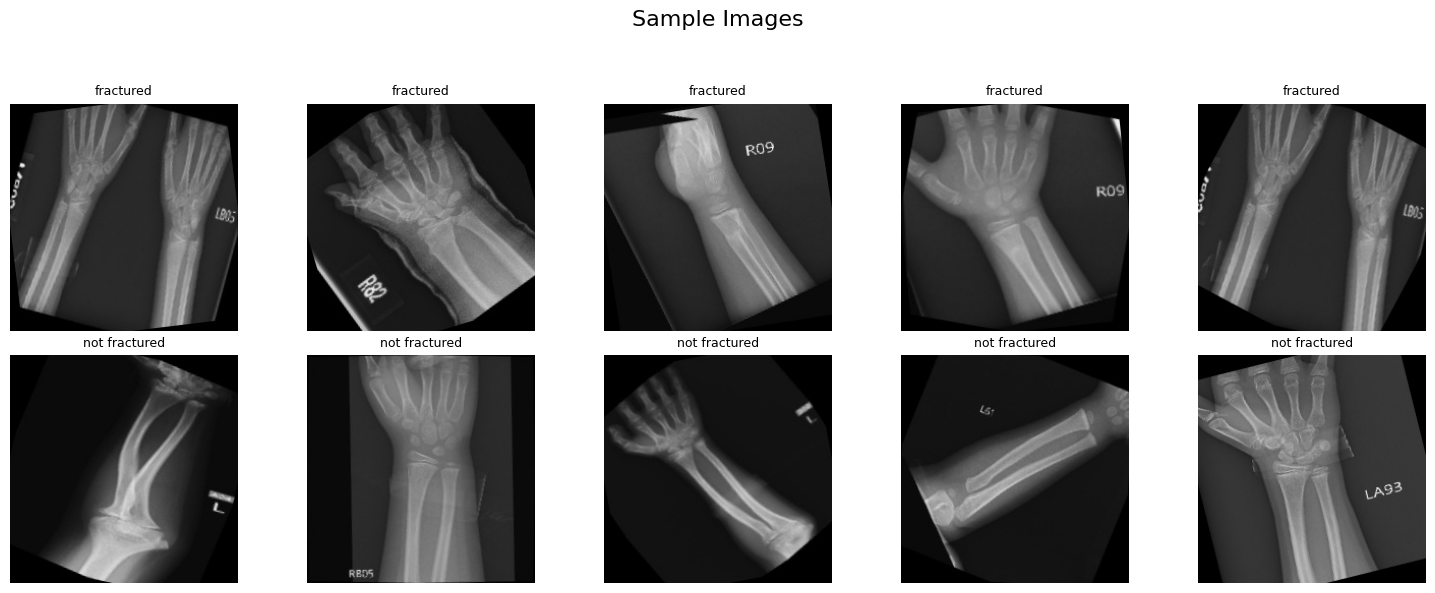

In [29]:
def show_images_from_dataset_folder(dataset_dir=None, total_per_class=5, title='Sample Images'):
    if dataset_dir == None:
        return "Tidak Ada Dataset Yang Diberikan"
    else:
        class_folders = sorted(os.listdir(dataset_dir))
        all_image_paths = []
        all_labels = []
    
        for class_name in class_folders:
            class_path = os.path.join(dataset_dir, class_name)
            if not os.path.isdir(class_path):
                continue  # skip file yang bukan folder
    
            all_files = os.listdir(class_path)
            # Amankan jika jumlah file lebih sedikit dari permintaan
            sample_files = all_files[:total_per_class] if len(all_files) < total_per_class else \
                           np.random.choice(all_files, total_per_class, replace=False)
    
            image_paths = [os.path.join(class_path, fname) for fname in sample_files]
            all_image_paths.extend(image_paths)
            all_labels.extend([class_name] * len(image_paths))
    
        total_classes = len(class_folders)
        total_images = len(all_image_paths)
    
        # Ukuran figure fleksibel
        plt.figure(figsize=(3 * total_per_class, 3 * total_classes))
        for i, (path, label) in enumerate(zip(all_image_paths, all_labels)):
            plt.subplot(total_classes, total_per_class, i + 1)
            plt.imshow(plt_image.imread(path))
            plt.title(label, fontsize=9)
            plt.axis('off')
    
        plt.suptitle(title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

show_images_from_dataset_folder(dataset_dir=train_dir, total_per_class=5, title='Sample Images')

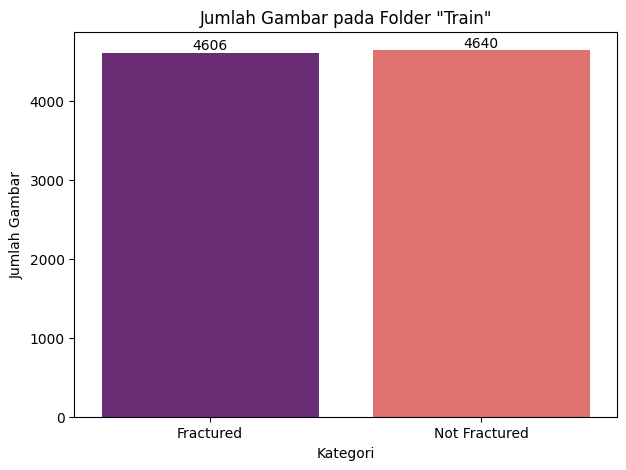

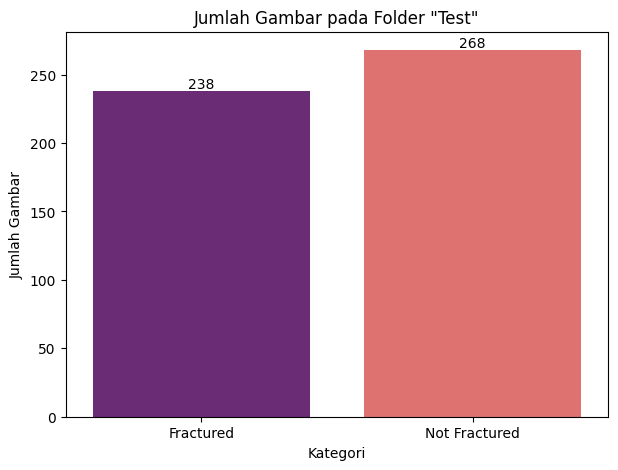

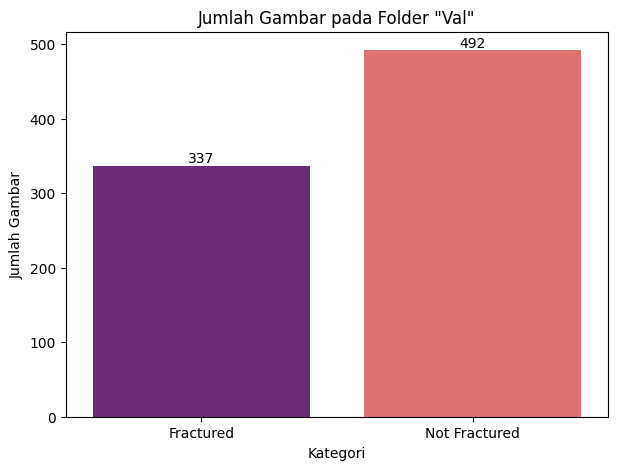

In [11]:
list_data_dir = [train_dir, test_dir, val_dir]
data_type = ['Train', 'Test', 'Val']

for idx, data in enumerate(list_data_dir):
    data_recent_fractured = os.path.join(data, class_names[0])
    len_data_recent_fractured = len(os.listdir(data_recent_fractured))

    data_recent_not_fractured = os.path.join(data, class_names[1])
    len_data_recent_not_fractured = len(os.listdir(data_recent_not_fractured))

    plt.figure(figsize=(7, 5))
    ax = sns.barplot(x=['Fractured', 'Not Fractured'], y=[len_data_recent_fractured, len_data_recent_not_fractured], palette='magma')

    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(f'{count}',              # teks label
                    (p.get_x() + p.get_width() / 2, count),  # posisi
                    ha='center', va='bottom', fontsize=10, fontweight=None)

    plt.title(f'Jumlah Gambar pada Folder "{data_type[idx]}"')
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah Gambar')
    plt.show() 

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=32,
                                                 class_mode='binary')

test_set = train_datagen.flow_from_directory(test_dir,
                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                             batch_size=32,
                                             class_mode='binary')

val_set = train_datagen.flow_from_directory(val_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=32,
                                            class_mode='binary')

Found 9246 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Found 829 images belonging to 2 classes.


In [14]:
model = Sequential([
    InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(training_set,
                   validation_data=test_set,
                   epochs=10
                   )

Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.6666 - loss: 0.5914 - val_accuracy: 0.8360 - val_loss: 0.4074
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.8868 - loss: 0.2795 - val_accuracy: 0.8735 - val_loss: 0.3220
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.9410 - loss: 0.1642 - val_accuracy: 0.9091 - val_loss: 0.2629
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.9634 - loss: 0.0974 - val_accuracy: 0.9249 - val_loss: 0.1900
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.9765 - loss: 0.0756 - val_accuracy: 0.9427 - val_loss: 0.1102
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.9805 - loss: 0.0641 - val_accuracy: 0.9506 - val_loss: 0.1673
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.9843 - loss: 0.0512 - val_accuracy: 0.9565 - val_loss: 0.1412
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.9839 - loss: 0.0420 - val_accu

In [17]:
def plot(hist):
  history = hist.history
  history['epoch'] = hist.epoch

  plt.figure(figsize=(12, 5))

  plt.subplot(121)
  plt.plot(history['epoch'], history['loss'], label='Loss')
  plt.plot(history['epoch'], history['val_loss'], label='Val Loss', color='orange')
  plt.legend()

  plt.subplot(122)
  plt.plot(history['epoch'], history['accuracy'], label='Acc')
  plt.plot(history['epoch'], history['val_accuracy'], label='Val Acc', color='orange')
  plt.legend()

  return plt.show()

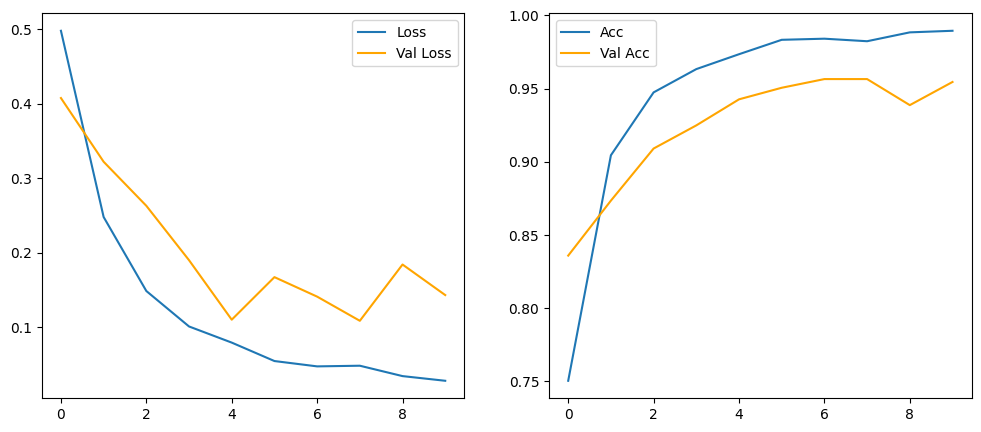

In [18]:
plot(history)

In [19]:
model.save('fracture_classification_model.h5')

In [20]:
loaded_model = tf.keras.models.load_model('fracture_classification_model.h5')

In [21]:
def load_preprocessed_image(image_path, img_height=180, img_width=180):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = os.path.join(train_dir, 'not fractured/2.png')
preprocessed_img = load_preprocessed_image(image_path)

In [22]:
predictions = loaded_model.predict(preprocessed_img)
predicted_class = np.argmax(predictions, axis=1)  # Assuming categorical output
class_names = ['fractured', 'not fractured']
# For binary classification, use:
predicted_class = (predictions > 0.5).astype("int32")

# Print the predicted class
print(f"Predicted class: {class_names[predicted_class[0][0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Predicted class: not fractured
